In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [82]:

def make_fake_data():
    t = np.linspace(0, 3, 200)**2
    y1 = np.sin(t)
    y2 = np.cos(1.3*t)
    y3 = np.heaviside(t-1, 0) - .5

    y = np.vstack((y1, y2, y3)).T
    y[175:, :] = np.array([[-.1, 0, .1]])

    print(f't = {t.shape}, y = {y.shape}')
    return t, y

def normalize_data(y):
    y_norm = (y  - y.min(axis=0, keepdims = True) )/ (y.max(axis=0, keepdims = True) - y.min(axis=0, keepdims = True))
    return y_norm

def get_distances(t1, y1, t2, y2, tn, yn):
    m = (y2-y1) / (t2 - t1)
    #print(m, tn, t1, t2, y1)
    y_fit = m * (tn - t1) + y1
    error = y_fit - yn
    return error



def get_crit_points(t, y, tolerance = 0.01, normalize = True, include_global_extrema = True):

    if normalize == True:
        y = normalize_data(y)

    if t.ndim == 1:
        t = t[:, np.newaxis]

    N_timepoints = y.shape[0]
    N_signals = y.shape[1]
    I_crit = np.zeros(N_timepoints, dtype=bool)

    I_crit[0] = True
    I_crit[-1] = True
    I_last_point = 0

    if include_global_extrema:
        I_max = np.argmax(y, axis=0)
        I_min =np.argmin(y, axis=0)
        I_crit[I_max] = True
        I_crit[I_min] = True


    for i in range(1, N_timepoints):
        
        if I_crit[i-1] == True:
            I_last_point = i-1
        else:
            t1 = t[I_last_point]
            t2 = t[i]
 
            y1 = y[[I_last_point], :]
            y2 = y[[i], :]    

            tn = t[I_last_point+1:i]
            yn = y[I_last_point+1:i, :]
            error = get_distances(t1, y1, t2, y2, tn, yn)

            if np.any(np.abs(error) >tolerance):
                I_last_point = i-1
                I_crit[I_last_point] = True

    return I_crit


def calculate_linear_interp_error(t, y, I_crit):

    y_interpolated = np.zeros_like(y)
    for i in range(y.shape[1]):  # vectorize this later
        y_interpolated[:, i] = np.interp(t, t[I_crit], y[I_crit,i])
    error = y_interpolated - y

    return error


t = (200,), y = (200, 3)


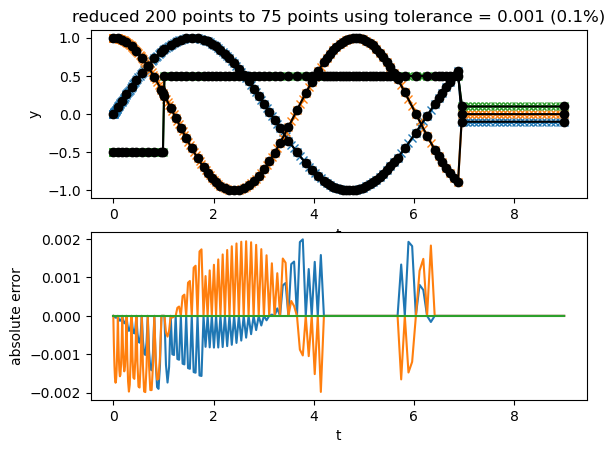

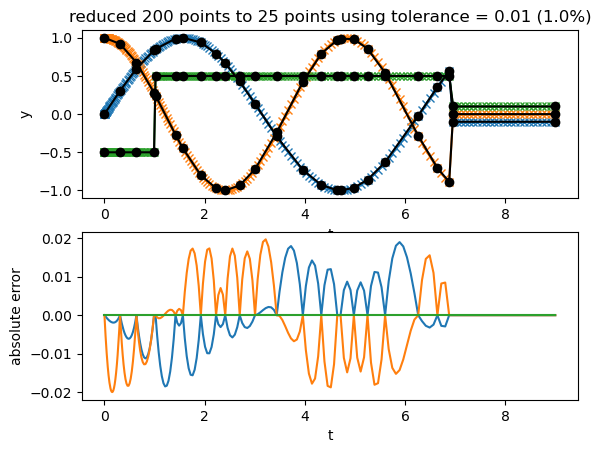

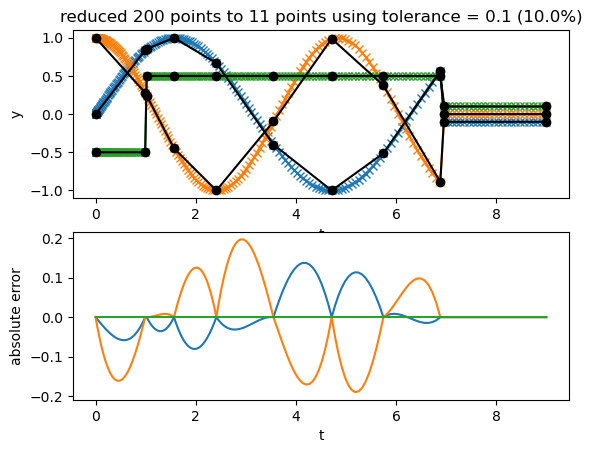

In [85]:
t, y = make_fake_data()

for tolerance in [0.001, 0.01, 0.1]:

    I_crit = get_crit_points(t, y, tolerance = tolerance)
    error = calculate_linear_interp_error(t, y, I_crit)

    fig, ax = plt.subplots(2, 1)    
    ax[0].plot(t, y, marker = 'x',)
    ax[0].plot(t[I_crit], y[I_crit], marker = 'o', color = 'k')
    ax[0].set_title(f'reduced {y.shape[0]} points to {np.sum(I_crit)} points using tolerance = {tolerance} ({tolerance*100:.1f}%)')
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('y')
    ax[1].plot(t, error)
    ax[1].set_xlabel('t')
    ax[1].set_ylabel('absolute error')

